In [2]:
from boto.s3.connection import S3Connection
import pyart
import gzip
from matplotlib import pyplot as plt
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import cartopy.crs as ccrs
%matplotlib inline

In [3]:
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-18:-3]
            fmt = '%Y%m%d_%H%M%S' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/pyart/io/nexrad_level2.py:169: UserWarning: No MSG5 detected. Setting to meaningless data. Rethink your life choices and be ready for errors.Specifically fixed angle data will be missing
  warnings.warn("No MSG5 detected. Setting to meaningless data. "
/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/pyart/io/nexrad_archive.py:209: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)
/home/mariofire/anaconda3/envs/meteorology/lib/python3.6/site-packages/pyart/graph/radarmapdisplay.py:258: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes.
  + "axes.", UserWarning)


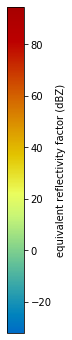

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyart
b_d = datetime(1999,12,24,3,0,0) #datetime.strptime(base_date, fmt)

radar = get_radar_from_aws('KOKX',b_d )
# Read in the file, create a RadarMapDisplay object
#filename = 'nsaxsaprppiC1.a1.20140201.184802.nc'
#radar = pyart.io.read(my_radar)
display = pyart.graph.RadarMapDisplay(radar)
loc = pyart.io.nexrad_common.get_nexrad_location('KOKX')
lon0 = loc[1] ; lat0 = loc[0]
radar.longitude['data'][0] = lon0
radar.latitude['data'][0] = lat0
radar.range['data'] = radar.range['data']+2500
radar.init_gate_altitude()
radar.init_gate_longitude_latitude()

# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])

fig = plt.figure(figsize=(6,6))
display.plot_ppi_map('reflectivity', sweep=1,
                     min_lon=-78, max_lon=-65, min_lat=40, max_lat=45,
                     lon_lines=np.arange(-78, -65, 2),
                     lat_lines=np.arange(40, 45, 1), 
                     fig=fig, lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0])

# Plot range rings at 10, 20, 30, 40km
display.plot_range_ring(10., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(30., line_style='k-')
display.plot_range_ring(40., line_style='k--')

# Plot cross hairs
display.plot_line_xy(np.array([-40000.0, 40000.0]), np.array([0.0, 0.0]),
                     line_style='k-')
display.plot_line_xy(np.array([0.0, 0.0]), np.array([-20000.0, 200000.0]),
                     line_style='k-')

# Indicate the radar location with a point
display.plot_point(radar.longitude['data'][0], radar.latitude['data'][0])
fig.gca().set_visible(False)
plt.show()

In [4]:
radar.range

{'units': 'meters',
 'standard_name': 'projection_range_coordinate',
 'long_name': 'range_to_measurement_volume',
 'axis': 'radial_range_coordinate',
 'spacing_is_constant': 'true',
 'comment': 'Coordinate variable for range. Range to center of each bin.',
 'data': array([  2125.,   2375.,   2625., ..., 461375., 461625., 461875.],
       dtype=float32),
 'meters_to_center_of_first_gate': -375.0,
 'meters_between_gates': 250.0}

In [5]:
radar.range['data'] = radar.range['data']-2500
radar.range

{'units': 'meters',
 'standard_name': 'projection_range_coordinate',
 'long_name': 'range_to_measurement_volume',
 'axis': 'radial_range_coordinate',
 'spacing_is_constant': 'true',
 'comment': 'Coordinate variable for range. Range to center of each bin.',
 'data': array([-3.75000e+02, -1.25000e+02,  1.25000e+02, ...,  4.58875e+05,
         4.59125e+05,  4.59375e+05], dtype=float32),
 'meters_to_center_of_first_gate': -375.0,
 'meters_between_gates': 250.0}

In [6]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (4028,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (4028,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	spectrum_width:
		data: <ndarray of type: float32 and shape: (4028, 1840)>
		units: meters_per_second
		standard_name: doppler_spectrum_width
		long_name: Spectrum Width
		valid_max: 63.0
		valid_min: -63.5
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	reflectivity:
		data: <ndarray of typ

In [7]:
from pyart.config import get_metadata

In [8]:
get_metadata('reflectivity')

{'units': 'dBZ',
 'standard_name': 'equivalent_reflectivity_factor',
 'long_name': 'Reflectivity',
 'coordinates': 'elevation azimuth range'}

In [9]:
radar.elevation

{'units': 'degrees',
 'standard_name': 'beam_elevation_angle',
 'long_name': 'elevation_angle_from_horizontal_plane',
 'axis': 'radial_elevation_coordinate',
 'comment': 'Elevation of antenna relative to the horizontal plane',
 'data': array([ 0.48339844,  0.48339844,  0.48339844, ..., 19.511719  ,
        19.511719  , 19.511719  ], dtype=float32)}

In [10]:
radar.init_gate_altitude()

In [11]:
radar.init_gate_longitude_latitude()

In [12]:
radar

In [13]:
radar.gate_latitude['data']

array([[40.86551853, 40.8655462 , 40.86557379, ..., 40.78798095,
        40.7878692 , 40.7877574 ],
       [40.86545905, 40.86552637, 40.86559361, ..., 40.86054897,
        40.8604765 , 40.86040397],
       [40.86540219, 40.86550742, 40.86561256, ..., 40.93000075,
        40.92996591, 40.929931  ],
       ...,
       [40.86448443, 40.86520149, 40.86591849, ..., 42.05705343,
        42.05763493, 42.0582166 ],
       [40.86453736, 40.86521914, 40.86590084, ..., 41.99238285,
        41.99292928, 41.99347587],
       [40.86459061, 40.86523689, 40.86588309, ..., 41.92738974,
        41.92790096, 41.92841233]])

In [14]:
radar

In [15]:
radar.init

AttributeError: 'Radar' object has no attribute 'init'